In [1]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA not available. Using CPU.")

CUDA not available. Using CPU.


# 1. Train

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
from torch.utils.data import DataLoader, Dataset

file_path = 'disease_symptoms_diagnosis.csv'
df = pd.read_csv(file_path)
df['combined_text'] = df['disease'] + " [SEP] " + df['diagnosis']

train_df, test_df = train_test_split(df, test_size=0.1)

class GPT2Dataset(Dataset):
    def __init__(self, texts, tokenizer, max_length):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return encoding['input_ids'].squeeze(0), encoding['attention_mask'].squeeze(0)

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

MAX_LEN = 256
BATCH_SIZE = 4

train_dataset = GPT2Dataset(train_df['combined_text'].tolist(), tokenizer, MAX_LEN)
train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)

test_dataset = GPT2Dataset(test_df['combined_text'].tolist(), tokenizer, MAX_LEN)
test_data_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

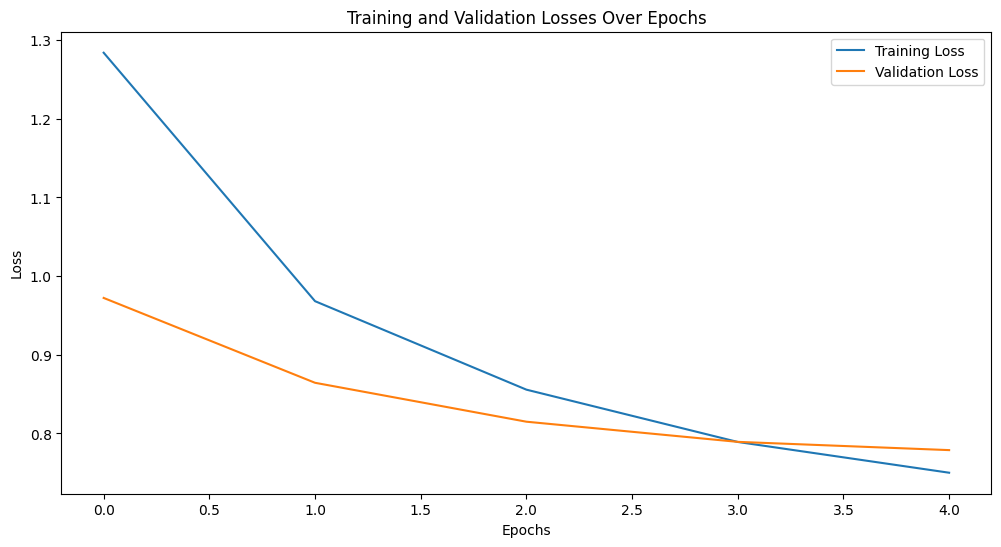

Epoch 5/5, Train Loss: 0.750056282776158, Val Loss: 0.7787893338081164


In [5]:
from transformers import AdamW, get_linear_schedule_with_warmup
from matplotlib import pyplot as plt
from IPython.display import clear_output

model = GPT2LMHeadModel.from_pretrained('gpt2')
model = model.to('cuda')

optimizer = AdamW(model.parameters(), lr=5e-5)
NUM_EPOCHS = 5
total_steps = len(train_data_loader) * NUM_EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

train_losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0
    for batch in train_data_loader:
        input_ids, attention_mask = [x.to(device) for x in batch]

        outputs = model(input_ids, labels=input_ids, attention_mask=attention_mask)
        loss = outputs.loss

        total_train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_data_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in test_data_loader:
            input_ids, attention_mask = [x.to(device) for x in batch]

            outputs = model(input_ids, labels=input_ids, attention_mask=attention_mask)
            loss = outputs.loss

            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(test_data_loader)
    val_losses.append(avg_val_loss)

    clear_output(wait=True)
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")

torch.save(model.state_dict(), "disease2diagnosis_gpt2_fine-tuned.pth")

# 2. Evaluation

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
from torch.utils.data import DataLoader, Dataset

In [10]:
file_path = 'disease_symptoms_diagnosis.csv'
#file_path = 'SymptomsXanswer-chat.csv'
df = pd.read_csv(file_path)

train_df, test_df = train_test_split(df, test_size=0.1)

In [11]:
test_query = []
test_response = []

for i in range(len(test_df)):
  test_response.append(test_df.iloc[i]['diagnosis'])
  test_query.append(test_df.iloc[i]['disease'])

print(len(test_response))
print(len(test_query))

310
310


In [38]:
test_chatbot = []

for i in range(50, len(test_query)):
#for i in range(50):
  tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
  tokenizer.pad_token = tokenizer.eos_token

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = GPT2LMHeadModel.from_pretrained('gpt2')
  model_path = 'disease2diagnosis_gpt2_fine-tuned.pth'
  model.load_state_dict(torch.load(model_path, map_location=device))
  model = model.to(device)

  input_text = test_query[i]
  input_ids = tokenizer.encode(input_text, return_tensors='pt')
  attention_mask = torch.ones(input_ids.shape, dtype=torch.long)

  # append the new user input tokens to the chat history
  #bot_input_ids = tokenizer.encode(test_query[i] + tokenizer.eos_token, return_tensors='pt')
  print("{} - Disease: {} \n".format(i, test_query[i]))
  print("{} - Reference:  {} \n".format(i, test_response[i]))

  # generated a response while limiting the total chat history to 1000 tokens,
  chat_history_ids = model.generate(
      input_ids,
      max_length=500,
      pad_token_id=tokenizer.eos_token_id,
      no_repeat_ngram_size=3,
      do_sample=True,
      top_k=10,
      top_p=0.7,
      temperature = 0.8,
      attention_mask=attention_mask,
      num_return_sequences=1
  )

  # pretty print last ouput tokens from bot
  print("{} - Predict: {} \n\n".format(i, tokenizer.decode(chat_history_ids[:, input_ids.shape[-1]:][0], skip_special_tokens=True).strip().replace('[SEP]', '')))
  test_chatbot.append(tokenizer.decode(chat_history_ids[:, input_ids.shape[-1]:][0], skip_special_tokens=True).strip().replace('[SEP]', ''))

print(len(test_chatbot))

50 - Disease: Common Cold 

50 - Reference:  I'm sorry to hear that you're feeling unwell. Based on your symptoms, it's possible that you have a respiratory infection. The combination of sneezing, chills, weakness, tiredness, cough, and high fever could indicate a viral or bacterial infection. It's important to rest and stay hydrated to help your body fight off the infection. You can try over-the-counter medications like acetaminophen or ibuprofen to help reduce fever and relieve any discomfort. However, I would recommend consulting with a healthcare professional for a proper diagnosis and treatment plan. They may prescribe antiviral or antibiotic medications if necessary. 

50 - Predict:  Based on your symptoms, it is possible that you are experiencing a respiratory infection or a respiratory tract infection. The combination of high fever, cough, sore throat, and muscle ache could indicate a common cold or flu. However, I am not able to provide a definitive diagnosis without a physica

In [39]:
df_eval_500_2 = pd.DataFrame(columns=[test_query[50:], test_response[50:], test_chatbot]).transpose()

In [41]:
df_eval_500_2.tail(1)

,,
Hirsutism,"Excessive hair growth in women, also known as hirsutism, can be caused by various factors. It is important to identify the underlying cause in order to determine the appropriate treatment. Common causes of hirsutism include hormonal imbalances, such as polycystic ovary syndrome (PCOS), adrenal gland disorders, and certain medications. In some cases, it may be hereditary. If you suspect hormonal imbalances, I recommend consulting with a healthcare professional who can conduct a thorough evaluation and recommend appropriate tests. Treatment options may include hormonal medications such as oral contraceptives or anti-androgens, which can help regulate hormone levels and reduce excessive hair growth. In addition to medical treatments, there are also some self-care measures you can take to manage excessive hair growth. These include: 1. Shaving: Regularly shaving the affected areas can help manage the appearance of excessive hair growth. 2. Waxing or threading: These methods can provide longer-lasting results compared to shaving. 3. Laser hair removal: This procedure uses laser technology to target and destroy hair follicles, resulting in long-term hair reduction. 4. Topical creams: Prescription creams containing eflornithine can help slow down hair growth. It's important to note that the effectiveness of these treatments may vary depending on the underlying cause of hirsutism. Therefore, it is advisable to consult with a healthcare professional for a proper diagnosis and personalized treatment plan.","Based on the symptoms you've described, it is possible that you may be experiencing a condition called dermatitis. Dermatitis is an inflammation of the skin caused by bacteria entering the skin and multiplying in the joints. The symptoms you mentioned, such as itching, redness, and swelling, are commonly associated with dermatitis, but they can also be caused by other conditions. To manage your symptoms, I recommend the following: 1. Keep your skin clean: Wash your face twice a day with a gentle cleanser specifically formulated for sensitive skin. Avoid scrubbing too harshly, as it can irritate the skin further. 2. Avoid touching or picking at the affected areas: If you suspect you may have developed a condition such as psoriasis, it would be best to avoid touching or touching your skin. Instead, try using a gentle, fragrance-free moisturizer to keep your skin hydrated and prevent further irritation. 3. Apply a topical corticosteroid cream: Over-the-counter hydrocortisone cream can help reduce inflammation and itching. Follow the recommended dosage instructions on the packaging. 4. Use over-the counter hydrocolloids: Nonsteroidal anti-inflammatory drugs (NSAIDs) like ibuprofen or naproxen can help relieve pain and reduce inflammation. Follow their recommended dosage. 5. Apply topical creams: Overdosing on certain creams or gels can help prevent dryness and itching caused by eczema. Follow instructions on their packaging. Alternatively, you can apply a topical cream containing hydrocodone cream to the affected area. 6. Use topical cream drips: Overuse and irritate your skin with a topical moisturizer or hydrocendrimal cream, which can help soothe dryness. However, it's important to follow the instructions on packaging and not use them as directed. 7. Use gentle cleansers: You can try using gentle cleansed cleansers containing ingredients like benzoyl peroxide or salicylic acid to soothe and hydrate your skin without clogging pores. However be sure to follow their instructions and not exceed the recommended usage limit. 8. Use a gentle moisturizer: Overclogging pores with harsh soaps or detergents can further irritate them further. You can apply gentle cleanses containing benzoyls or salicylates to the areas you like"


In [43]:
df_eval_500_2.to_csv('eval_2.csv')

In [23]:
import evaluate

In [44]:
eval_df = pd.read_csv('eval_data.csv')
predictions = eval_df.iloc[2]
references = eval_df.iloc[1]

In [45]:
perplexity = evaluate.load("perplexity", module_type="metric")
results = perplexity.compute(predictions=predictions, model_id='gpt2')
print(results)

  0%|          | 0/1 [00:00<?, ?it/s]

{'perplexities': [627.319091796875, 9.646150588989258, 9.49110221862793], 'mean_perplexity': 215.4854482014974}


In [46]:
rouge = evaluate.load('rouge')
results = rouge.compute(predictions=predictions, references=references)
print(results)

{'rouge1': 0.3091307488850014, 'rouge2': 0.13974571586511886, 'rougeL': 0.1869416299975919, 'rougeLsum': 0.1869416299975919}


In [47]:
bleu = evaluate.load("bleu")
results = bleu.compute(predictions=predictions, references=references)
print(results)

{'bleu': 0.18578095434612377, 'precisions': [0.531322505800464, 0.2523364485981308, 0.16, 0.11347517730496454], 'brevity_penalty': 0.8363949975770439, 'length_ratio': 0.8484251968503937, 'translation_length': 431, 'reference_length': 508}


In [48]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from nltk.translate.bleu_score import SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from nltk.translate.nist_score import sentence_nist
from nltk.tokenize import word_tokenize

def get_metrics(pred, target):
    turns = len(target)
    bleu_2 = 0
    bleu_4 = 0
    meteor = 0
    nist_2 = 0
    nist_4 = 0
    for index in range(turns):
        pred_utt = pred[index]
        target_utt = target[index]
        min_len = min(len(pred_utt), len(target_utt))
        lens = min(min_len, 4)
        if lens == 0:
            continue
        if lens >= 4:
            bleu_4_utt = sentence_bleu([target_utt], pred_utt, weights = (0.25, 0.25, 0.25, 0.25), smoothing_function = SmoothingFunction().method1)
            nist_4_utt = sentence_nist([target_utt], pred_utt, 4)
        else:
            bleu_4_utt = 0
            nist_4_utt = 0
        if lens >= 2:
            bleu_2_utt = sentence_bleu([target_utt], pred_utt, weights = (0.5, 0.5), smoothing_function = SmoothingFunction().method1)
            nist_2_utt = sentence_nist([target_utt], pred_utt, 2)
        else:
            bleu_2_utt = 0
            nist_2_utt = 0
            
        bleu_2 += bleu_2_utt
        bleu_4 += bleu_4_utt
        meteor += meteor_score([word_tokenize(target_utt)], word_tokenize(pred_utt))
        nist_2 += nist_2_utt
        nist_4 += nist_4_utt
        
    bleu_2 /= turns
    bleu_4 /= turns
    meteor /= turns
    nist_2 /= turns
    nist_4 /= turns
    return bleu_2, bleu_4, meteor, nist_2, nist_4


In [49]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

bleu_2, bleu_4, meteor, nist_2, nist_4 = get_metrics(predictions, references)
bleu_2, bleu_4, meteor, nist_2, nist_4

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


(0.4992902561999877,
 0.3701430399991496,
 0.21043413900007624,
 4.268435966524554,
 4.94792769312318)